In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image

lr = 7.0
size = 224
iterations = 50
style_wt = 1e5
content_wt = 1.0

content_image_path = r"C:\Users\KIIT\Pictures\Red mi 5a\IMG_20200218_175012 (2).jpg"
style_image_path = r"C:\Users\KIIT\Pictures\Red mi 5a\.wallpaper\international_building (6)_&_039145ff-3204-406e-aff6-b881496641ab.jpg"

print("TensorFlow version:", tf.__version__)

style_layer_wts = [1.0, 0.8, 0.1, 0.1, 0.2]

TensorFlow version: 2.0.0


In [20]:
model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(size, size, 3))
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [22]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        image = image[0,:,:,:]

    img = deprocess(image)
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

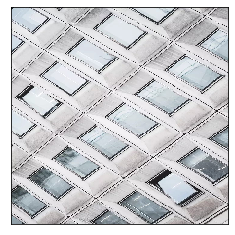

In [23]:
display_image(preprocess_image(style_image_path))

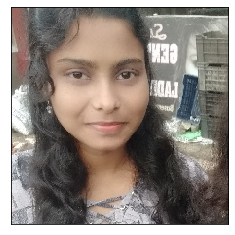

In [24]:
display_image(preprocess_image(content_image_path))

In [25]:
content_layer = 'block4_conv2'

content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

In [26]:
style_layers = [
    'block1_conv1', 'block1_conv2',
    'block2_conv1', 'block2_conv2',
    'block3_conv1'
    ]

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

Related: An easy approach to [feature visualization](https://github.com/am1tyadav/feature-visualization)

In [27]:
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost = tf.reduce_mean(tf.square(C - G))
    return cost

In [28]:
def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G / tf.cast(n, dtype=tf.float32)

In [29]:
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

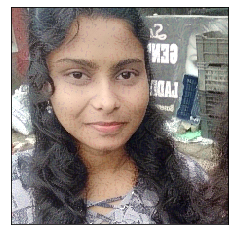

Iteration:1/50, Total Cost:608890560.0, Style Cost: 6088.90576171875, Content Cost: 0.0


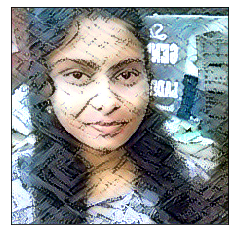

Iteration:11/50, Total Cost:159825008.0, Style Cost: 1592.0194091796875, Content Cost: 623071.0625


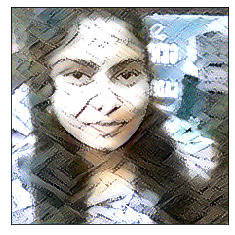

Iteration:21/50, Total Cost:40104560.0, Style Cost: 393.7255859375, Content Cost: 732001.5


In [ ]:
content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []

optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 10 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

In [ ]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [15]:
image = Image.fromarray(deprocess(generated_images[-1][0]))

In [ ]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('out.png')